In [7]:
from keras.layers import Input,Dense
from keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import keras

In [8]:
%%time
import os
for dirPath, dirNames, fileNames in os.walk("figure"):
    pass
data=[]
for name in fileNames:
    path='figure/'+name
    img=mpimg.imread(path)
    #data.append(img[6:34,6:34,0:4])
    data.append(img[4:36,4:36,0:4])
data=np.array(data)

x_train=data[:-3]
x_test=data[-3:]

x_train=x_train.reshape(len(x_train),32,32,4)
x_test=x_test.reshape(len(x_test),32,32,4)

print('x_train shape=',x_train.shape)
print('x_test shape=',x_test.shape)

x_train shape= (789, 32, 32, 4)
x_test shape= (3, 32, 32, 4)
CPU times: user 161 ms, sys: 16.6 ms, total: 177 ms
Wall time: 178 ms


In [9]:
import os
for dirPath, dirNames, fileNames in os.walk("/Users/chiang/Downloads/POKEMON/"):
    pass
data=[]
for name in fileNames:
    if name[-4:]=='.ico':
        pass
    else:
        continue
    path='/Users/chiang/Downloads/POKEMON/'+name
    img=mpimg.imread(path)
    #data.append(img[6:34,6:34,0:4])
    data.append(img[:,:,:])
data=np.array(data)

x_train=data[:-3]
x_test=data[-3:]
x_train=x_train.astype(np.float32)/255
x_test=x_test.astype(np.float32)/255
#x_train=x_train.reshape(len(x_train),32,32,4)
#x_test=x_test.reshape(len(x_test),32,32,4)

print('x_train shape=',x_train.shape)
print('x_test shape=',x_test.shape)

x_train shape= (551, 256, 256, 4)
x_test shape= (3, 256, 256, 4)


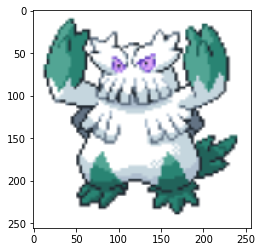

In [10]:
img=mpimg.imread('/Users/chiang/Downloads/POKEMON/'+fileNames[500])
imgplot = plt.imshow(img)
plt.show()

In [13]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Layer, Lambda, Flatten,Conv2DTranspose
from keras.models import Model
from keras import backend as K

input_img=Input(shape=(256,256,4))

conv1=Conv2D(64,(2,2),activation='relu',padding='same',strides=1)(input_img)
maxpool1=MaxPooling2D((4,4),padding='same')(conv1)
conv2=Conv2D(64,(2,2),activation='relu',padding='same',strides=1)(maxpool1)
maxpool2=MaxPooling2D((2,2),padding='same')(conv2)
conv3=Conv2D(64,(2,2),activation='relu',padding='same',strides=1)(maxpool2)
maxpool3=MaxPooling2D((2,2),padding='same')(conv3)
flat=Flatten()(maxpool3)
dense1=Dense(16*16*2)(flat)
dense2=Dense(16*8)(dense1)
z_mean=Dense(32)(dense2)
z_log_var=Dense(32)(dense2)
def sampling(args):
    z_mean, z_log_var = args
    #epsilon是常態分布下亂數取出的noise
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 1), mean=0.,
                              stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon
z = Lambda(sampling)([z_mean, z_log_var])
encoder=Model(input_img,z)

decoder_input=Input(shape=(32,))
dec_dense1=Dense(16*8)
dec_dense2=Dense(16*16*2)
dec_dense3=Dense(16*16*64)
dec_reshape=Reshape((16,16,64))
dec_conv1=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=1)
dec_ups1=UpSampling2D((2,2))
dec_conv2=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=1)
dec_ups2=UpSampling2D((2,2))
dec_conv3=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=1)
dec_ups3=UpSampling2D((4,4))
dec_conv4=Conv2D(4,(3,3),activation='sigmoid',padding='same',strides=1)

x=dec_dense1(z)
x=dec_dense2(x)
x=dec_dense3(x)
x=dec_reshape(x)
x=dec_conv1(x)
x=dec_ups1(x)
x=dec_conv2(x)
x=dec_ups2(x)
x=dec_conv3(x)
x=dec_ups3(x)
x=dec_conv4(x)

decoder=dec_dense1(decoder_input)
decoder=dec_dense2(decoder)
decoder=dec_dense3(decoder)
decoder=dec_reshape(decoder)
decoder=dec_conv1(decoder)
decoder=dec_ups1(decoder)
decoder=dec_conv2(decoder)
decoder=dec_ups2(decoder)
decoder=dec_conv3(decoder)
decoder=dec_ups3(decoder)
decoder=dec_conv4(decoder)

decoder=Model(decoder_input,decoder)


from keras import metrics
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        # 呼叫Layer的建構子__init__
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, input_img, x):
        input_img=Flatten()(input_img)
        x=Flatten()(x)
        xent_loss = 256 *256* (metrics.binary_crossentropy((input_img), (x)))
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),axis=1)
        return K.sum(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([input_img, x])
vae = Model(input_img, y)
vae.compile(optimizer='RMSprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 256, 256, 64) 1088        input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 64, 64, 64)   16448       max_pooling2d_6[0][0]            
__________________________________________________________________________________________________
max_poolin

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:91: UserWarning: Output "custom_variational_layer_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_4" during training.


In [14]:
vae.fit(x=x_train,shuffle=True,epochs=5,validation_data=(x_test,None),batch_size=16)


import json
from keras.applications import imagenet_utils
vae.save_weights('./vae3_weight.h5')

Train on 551 samples, validate on 3 samples
Epoch 1/5
551/551 [==============================] - 132s 239ms/step - loss: 482368.7170 - val_loss: 85587.6875
Epoch 2/5
551/551 [==============================] - 130s 235ms/step - loss: 289043.4844 - val_loss: 75998.2656
Epoch 3/5
551/551 [==============================] - 131s 237ms/step - loss: 281311.3351 - val_loss: 65232.2266
Epoch 4/5
551/551 [==============================] - 130s 237ms/step - loss: 262659.2143 - val_loss: 51762.4844
Epoch 5/5
551/551 [==============================] - 130s 236ms/step - loss: 250938.6348 - val_loss: 53871.2188


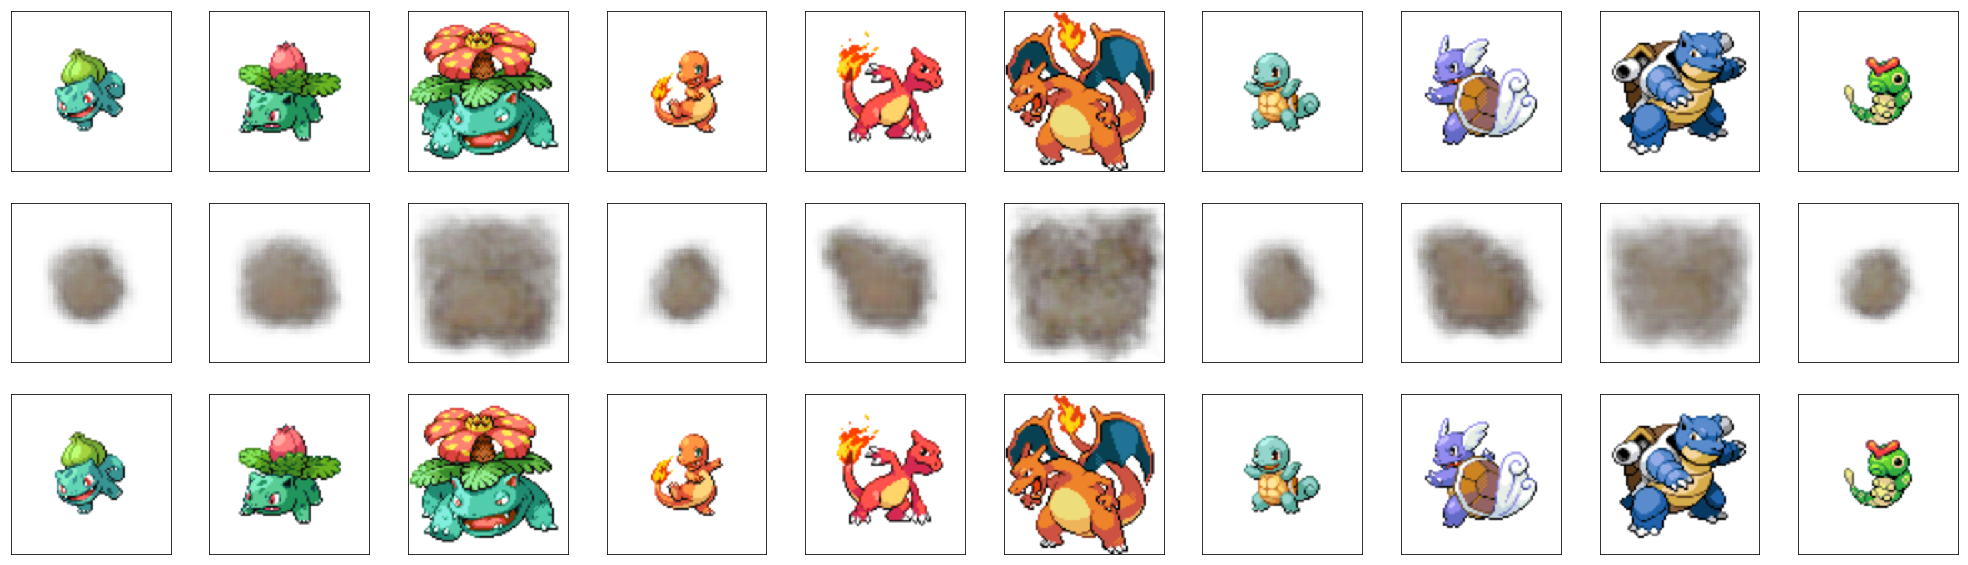

In [42]:
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)
hello=vae.predict(x_train)
n = 10  # how many digits we will display
plt.figure(figsize=(35, 10))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    imgplot = plt.imshow(x_train[0+i][:,:,])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    imgplot = plt.imshow(decoded_imgs[0+i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + 2*n)
    imgplot = plt.imshow(hello[0+i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
hello=vae.predict(x_test)
n = 3  # how many digits we will display
plt.figure(figsize=(10, 10))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    imgplot = plt.imshow(x_test[i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    imgplot = plt.imshow(decoded_imgs[i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + 2*n)
    imgplot = plt.imshow(hello[i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

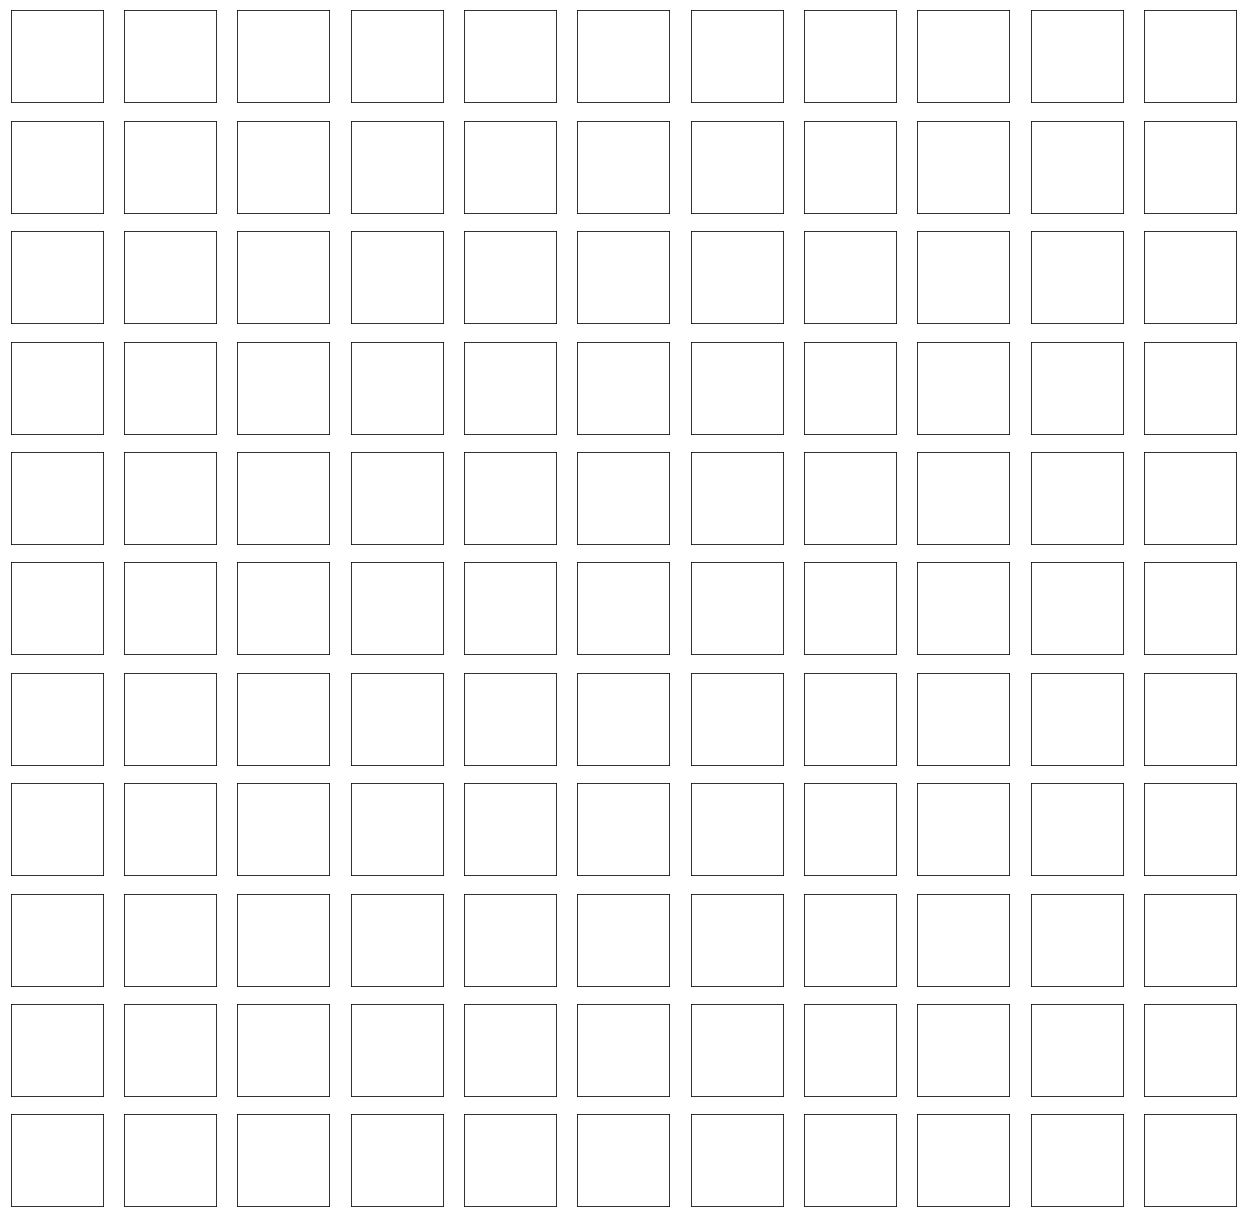

In [6]:
import random
base_img=encoded_imgs[151]
grid=[-2+0.4*i for i in range(11)]
'''for i in range(30):
    base_img[2+i]=random.random()*2-1'''
#base_img[2:]=1
n = 11  # how many digits we will display
plt.figure(figsize=(22, 22))
for i in range(11):
    for j in range(11):
    # display original
        ax = plt.subplot(11, n, 11*i +j+ 1)
        target_img=base_img.copy()
        target_img[0]=grid[j]
        target_img[1]=grid[i]
        result=decoder.predict(target_img.reshape((1,32)))
        result=result.reshape((32,32,4))
        imgplot = plt.imshow(result)
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
from keras.models import model_from_json
vae.load_weights('./vae2_weight.h5')

